### Programming Assignment 1 Q1
### Decision Tree

Group Number : 46

Student 1 : Aryan Singh 19CS30007

Student 2 : Seemant Guruprasad Achari 19CS30057


In [1]:
import numpy as np
import pandas as pd
from graphviz import Digraph

import matplotlib.pyplot as plt


In [2]:
# A constant to reference the result column
LABEL = 'Response'

# a limit for the number of decision that are allowed for a particular attribute
POTENTIAL_SPLIT_LIMIT = 10

# max unique categories to consider
MAX_UNIQUE_CATEGORIES = 20

# tag for categorical attributes
CATEGORICAL_FEATURE = "categorical"

# tag for continuous attributes
CONTINUOUS_FEATURE = "continuous"

# Flags for pruning function, based on this you can choose the preferred pruning method.
ACC_BASED_PRUNING = 0 # Accuracy focussed pruning
PRE_BASED_PRUNING = 1 # Precision focussed pruning
REC_BASED_PRUNING = 2 # Recall focussed pruning

# Pruning considered only if when the prunded tree has atleast this much recall
# Since high accuracy with very low recall is of no real application
RECALL_LIMIT_THRESHOLD = 0.25 

# Data read using pandas
df = pd.read_csv('Dataset_C.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131689 entries, 0 to 131688
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    131689 non-null  int64 
 1   Gender                131689 non-null  object
 2   Age                   131689 non-null  int64 
 3   Driving_License       131689 non-null  int64 
 4   Region_Code           131689 non-null  int64 
 5   Previously_Insured    131689 non-null  int64 
 6   Vehicle_Age           131689 non-null  object
 7   Vehicle_Damage        131689 non-null  object
 8   Annual_Premium        131689 non-null  int64 
 9   Policy_Sales_Channel  131689 non-null  int64 
 10  Vintage               131689 non-null  int64 
 11  Response              131689 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 12.1+ MB


In [4]:
# splitting dataset index maintaing the ratio of true and false examples
def train_test_split(df,train_sample=0.5,target_col= LABEL):
    all_indexes=[]
    df_grouped= df.groupby(target_col)
    for x,x_df in df_grouped:
        t = x_df.sample(frac=train_sample,).index
        all_indexes.append(t)
    g = all_indexes[0].values
    for k in all_indexes[1:]:
        g=np.hstack([g,k.values])
        #np.hstack([all_indexes[0].values,all_indexes[1].values])

    train_df = df[df.index.isin(g) ]
    test_df = df[~df.index.isin(g)]
    return train_df, test_df 

In [5]:
# Classifying the attributes as continuous or categorical feature

print("Analzing dataset")
for k in df.columns:
    if k == 'id':
        continue
    if k == LABEL :
        print("Label     => ", end = "")
    else:
        print("Attribute => ", end = "")
    print(f"{k} has {len(df[k].unique())} unique values.", end="")
    if(len(df[k].unique()) <= MAX_UNIQUE_CATEGORIES):
        print("[ ", end = "")
        for val in df[k].unique():
            print(val, end = ", ")
        print("]", end="")
    print()
print()
def determineTypeOfFeature(df):
    print("Determining type of feature")
    feature_types = {}
    n_unique_values_treshold = MAX_UNIQUE_CATEGORIES
    for feature in df.columns:
        if feature == 'id':
            continue
        if feature != LABEL:
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types[feature] = CATEGORICAL_FEATURE
            else:
                feature_types[feature] = CONTINUOUS_FEATURE
    
    return feature_types
# Generating a constant map which we will use to potentialSplit
FEATURE_TYPES = determineTypeOfFeature(df)
for k, v in FEATURE_TYPES.items():
    print(f"Attr {k} is {v}")

Analzing dataset
Attribute => Gender has 2 unique values.[ Male, Female, ]
Attribute => Age has 66 unique values.
Attribute => Driving_License has 2 unique values.[ 1, 0, ]
Attribute => Region_Code has 53 unique values.
Attribute => Previously_Insured has 2 unique values.[ 0, 1, ]
Attribute => Vehicle_Age has 3 unique values.[ > 2 Years, 1-2 Year, < 1 Year, ]
Attribute => Vehicle_Damage has 2 unique values.[ Yes, No, ]
Attribute => Annual_Premium has 36617 unique values.
Attribute => Policy_Sales_Channel has 140 unique values.
Attribute => Vintage has 290 unique values.
Label     => Response has 2 unique values.[ 1, 0, ]

Determining type of feature
Attr Gender is categorical
Attr Age is continuous
Attr Driving_License is categorical
Attr Region_Code is continuous
Attr Previously_Insured is categorical
Attr Vehicle_Age is categorical
Attr Vehicle_Damage is categorical
Attr Annual_Premium is continuous
Attr Policy_Sales_Channel is continuous
Attr Vintage is continuous


In [6]:
#  This method returns the potential_splits for a given attributes
def getPotentialSplits(featureName, trainData):
    
    potential_splits = []
    values = trainData[featureName]
    unique_values = np.unique(values)
    
    type_of_feature = FEATURE_TYPES[featureName]
    if type_of_feature == CONTINUOUS_FEATURE:
        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2
                
                potential_splits.append(potential_split)
        
        # Since the potential_splits can have thousands of options, we need to drop some of them to reduce the complexity
        if(len(potential_splits) > POTENTIAL_SPLIT_LIMIT):
            endIdx = len(potential_splits)
            incrementBy = (endIdx + POTENTIAL_SPLIT_LIMIT -1)// POTENTIAL_SPLIT_LIMIT
            potential_splits = potential_splits[::incrementBy]
    
    else:
        potential_splits = unique_values
    
    return potential_splits

# Returns the features list from the set of attributes name
def getFeaturesList(trainData, featureSet):
    featuresList = []
    for key, value in FEATURE_TYPES.items():
        if key not in featureSet:
            continue
        if(value == CONTINUOUS_FEATURE):
            potentialSplits = getPotentialSplits(key, trainData)
            for potentialSplit in potentialSplits:
                featuresList.append([key, potentialSplit])
        else:
            featuresList.append([key])
    
    return featuresList  

# Method to Calulate Total Entropy

# Input : Traning Data, label, classList

def calculateTotalEntropy(trainData, label, classList):
    totalCount = trainData.shape[0]

    totalEntropy = 0

    for c in classList:
        # Count the number of data points which satify == c class constraints
        totalClassCount = trainData[trainData[label] == c].shape[0]
        # Calulate the class's entropy
        totalClassEntropy = 0
        prob = totalClassCount / totalCount
        if( prob >0):
            totalClassEntropy = - (prob)*np.log2(prob)
        # Accumulate the class's entropy into the totalEntropy
        totalEntropy = totalEntropy + totalClassEntropy
    
    return totalEntropy

def calculateEntropy(featureValueData, label, classList):
    classCount = featureValueData.shape[0]
    entropy = 0

    for c in classList:
        # Count the number of data points withing the featureValueData which satify == c class constraints
        labelClassCount = featureValueData[featureValueData[label] == c].shape[0]
        classEntropy = 0
        if labelClassCount != 0:
            # if labelClassCount != 0 then calculate its entropy
            prob = labelClassCount/classCount
            if prob !=0:
                classEntropy = -prob * np.log2(prob)
        # Accumulate its entropy
        entropy = entropy + classEntropy
    return entropy


# Calculates the information gain for a split on feature
def calulateInformationGain(feature, trainData, label, classList):
    featureName = feature[0]
    threshold = None

    totalCount = trainData.shape[0]
    featureInfo = 0.0
        
    if(FEATURE_TYPES[featureName] == CONTINUOUS_FEATURE):
        # For cases when value <= threshold
        threshold = feature[1]
        featureValueData = trainData[trainData[featureName] <= threshold]
        featureValueCount = featureValueData.shape[0]
        featureValueEntropy = calculateEntropy(featureValueData, label, classList)
        featureValueProbability = featureValueCount / totalCount
        featureInfo += featureValueProbability * featureValueEntropy

        # For cases when value > threshold
        featureValueData = trainData[trainData[featureName] > threshold]
        featureValueCount = featureValueData.shape[0]
        featureValueEntropy = calculateEntropy(featureValueData, label, classList)
        featureValueProbability = featureValueCount / totalCount
        featureInfo += featureValueProbability * featureValueEntropy
    else:
        # Categorical Case
        featureValueList = trainData[featureName].unique()
        for featureValue in featureValueList:
            featureValueData = trainData[trainData[featureName] == featureValue]
            featureValueCount = featureValueData.shape[0]
            featureValueEntropy = calculateEntropy(featureValueData, label, classList)
            featureValueProbability = featureValueCount / totalCount
            featureInfo += featureValueProbability * featureValueEntropy
    
    totalEntropy = calculateTotalEntropy(trainData, label, classList)

    gain = totalEntropy - featureInfo
    
    return gain 


# Fetches the most important feature with maxInfoGain
def findMostImportantFeature(trainData, featureList, label, classList):
    
    maxInfoGain = -1 # init with smallest value possible
    maxInfoFeature = None
    # features are of two types: 
    # 1) Categorical, in which you iterate over multiple value of that feature
    # 2) Continous converted into binary category, i/p<= threshold or ip>threshold
    for feature in featureList:
        featureInfoGain = calulateInformationGain(feature, trainData, label, classList)
        if float(featureInfoGain) > float(maxInfoGain):
            maxInfoGain = featureInfoGain
            maxInfoFeature = feature
    return maxInfoFeature


Class for decision node and tree

In [ ]:
#  passing same feature list
class DecisionNode:
    nodeId = 0
    '''
    decisionThreshold and prePruningThreshold are design parameters.
    '''
    decisionThreshold = .35
    prePruningThreshold = 40
    def __init__(self, featureSet, label, classList, decisionNodeName, depth, max_depth):
        # print(depth, decisionNodeName)
        self.nodeId = DecisionNode.nodeId
        DecisionNode.nodeId += 1
        self.featureSet = featureSet
        # print(f"Cur feature set{self.featureSet}")
        self.decisionNodeName = decisionNodeName
        self.label = label
        self.classList = classList
        self.leafNode = False
        self.isPruned = False
        self.depth = depth
        self.max_depth = max_depth
        if( self.depth == max_depth ):
            self.isPruned = True
    
    def fitData(self, trainData):
        label = self.label
        classList = self.classList
        self.featureList = getFeaturesList(trainData, self.featureSet)
        self.labelDistribution = {}
        for c in self.classList:
            cnt = trainData[trainData[label]==c].shape[0]
            self.labelDistribution[c] = cnt
        # print(self.labelDistribution )
        self.trainDataCount = trainData.shape[0]
        self.currentNodeReturnVal =  self.bestOption() # return this if you cant decide
        self.inpurity = calculateTotalEntropy(trainData, label, classList)
        # print(f"Impurity = {self.inpurity} @depth = {self.depth}")
        if(self.labelDistribution[0]==0 or self.labelDistribution[1] == 0 or self.isPruned or self.prePruning()):
            self.leafNode = True

        self.childrenNode = {}
        if(not self.leafNode):
            label = self.label
            classList = self.classList
            retVal = findMostImportantFeature(trainData, self.featureList, label, classList)
            if(retVal == None):
                self.leafNode = True
                self.decisionNodeName = self.decisionNodeName
                self.bestFeatureName = "Ans = " + str(self.currentNodeReturnVal)
                return
            self.bestFeatureName = retVal[0]
            # print(self.bestFeatureName)
            newFeatureSet = self.featureSet.copy()
            # newFeatureSet.remove(self.bestFeatureName)
            if(FEATURE_TYPES[self.bestFeatureName] == CONTINUOUS_FEATURE):
                self.threshold = retVal[1]
                # print(f"threshold = {self.threshold}")
                # left is <= threshold
                nextNodeName = self.bestFeatureName + " <= " + str(self.threshold)
                # print(f"The next node will go by the name {nextNodeName}")
                node = DecisionNode(newFeatureSet, self.label, self.classList, nextNodeName, self.depth + 1, self.max_depth)
                node.fitData(trainData[trainData[self.bestFeatureName] <= self.threshold])
                self.childrenNode[True] = (node)

                # right is > threshold
                nextNodeName = self.bestFeatureName + " > " + str(self.threshold)
                # print(f"The next node will go by the name {nextNodeName}")
                node = DecisionNode(newFeatureSet, self.label, self.classList, nextNodeName, self.depth + 1, self.max_depth)
                node.fitData(trainData[trainData[self.bestFeatureName] > self.threshold])
                self.childrenNode[False] = (node)

            else:
                attributeValues = trainData[self.bestFeatureName].unique()
                for nextValue in attributeValues:
                    nextNodeName = self.bestFeatureName + " == " + str(nextValue)
                    # print(f"The next node will go by the name {nextNodeName}")
                    node = DecisionNode(newFeatureSet, self.label, self.classList, nextNodeName, self.depth + 1, self.max_depth)
                    node.fitData(trainData[trainData[self.bestFeatureName] == nextValue])
                    # print(node)
                    self.childrenNode[nextValue] = node

        else:
            
            self.decisionNodeName = self.decisionNodeName
            self.bestFeatureName = "Ans = " + str(self.currentNodeReturnVal)
    def predict(self, x_hat):
        if(self.leafNode or self.isPruned):
            # returning the majority decision
            return self.currentNodeReturnVal
        # we need to traverse down the tree
        if(FEATURE_TYPES[self.bestFeatureName] == CONTINUOUS_FEATURE):
            nextNode = (x_hat[self.bestFeatureName] <= self.threshold)
        else:
            nextNode = x_hat[self.bestFeatureName]
        if(nextNode not in self.childrenNode.keys()):
            # print(self.bestFeatureName)
            # print(f"xhat = {x_hat}")
            # print(f"nextNode = {nextNode}")
            # print(f"childrenNode = {self.childrenNode.keys()}")
            return self.currentNodeReturnVal
        return self.childrenNode[nextNode].predict(x_hat)

    def tempPrune(self):
        self.isPruned = True

    def unPrune(self):
        self.isPruned = False
    
    def Prune(self):
        self.isPruned = True
        self.leafNode = True
        self.bestFeatureName = "Ans = " + str(self.currentNodeReturnVal)
    def prePruning(self):
        self.isPruned = self.labelDistribution[1] < DecisionNode.prePruningThreshold
        return self.isPruned

    def __repr__(self):
        return f"Name: {self.decisionNodeName}\nData Count: {self.trainDataCount}\nFeature: {self.bestFeatureName}\nChildren: {len(self.childrenNode)}\n"

    def bestOption(self):
        dist = self.labelDistribution
        if(dist[0] == 0 or dist[1]/dist[0] > DecisionNode.decisionThreshold):
            return 1
        else:
            return 0

        

In [ ]:
class DecisionTree:
    def __init__(self, featureSet, label, classList, rootName, max_depth):
        DecisionNode.nodeId = 0
        self.max_depth = max_depth
        self.root= DecisionNode(featureSet, LABEL, classList, rootName, 0, max_depth)
        self.treeDepth = 0
    
    def fitData(self, trainData):
        self.root.fitData(trainData)
    
    def predict(self, x):
        return self.root.predict(x)
    
    def getTreeDepth(self):
        maxDepthTillNow = 0
        node = self.root
        st = [node]

        while(len(st)>0):
            node = st.pop()
            maxDepthTillNow = max(maxDepthTillNow, node.depth)
            if(node.leafNode):
                continue
            for key in node.childrenNode:
                st.append(node.childrenNode[key])
        return maxDepthTillNow
    
    def getTotalNodes(self):
        countOfNodes = 0
        node = self.root
        st = [node]

        while(len(st)>0):
            node = st.pop()
            countOfNodes += 1
            if(node.leafNode):
                continue
            for key in node.childrenNode:
                st.append(node.childrenNode[key])
        return countOfNodes


In [ ]:

# Evaluates tree Accuracy

def GetAccuracy(tree:DecisionTree, test_set, printDetails = True):
    cnt = 0
    outputs = {
        0: 0,
        1: 0
    }
    total_samples = 0
    root = tree.root
    for index, row in test_set.iterrows():
        y_hat = root.predict(row)
        outputs[y_hat] += 1
        cnt +=  (y_hat == row[LABEL])
        total_samples +=1
        # print(f"pediction = {root.predict(row)}, Real ={row[LABEL]}")
    accuracy = cnt / total_samples
    if(printDetails):
        print(f"Accuracy  = {cnt / total_samples} and Depth = {tree.getTreeDepth()}")
    
    return accuracy

# Evaluates tree precision for predicting 1
def GetPrecision(tree:DecisionTree, test_set, printDetails = True):
    cnt = 0
    outputs = {
        0: 0,
        1: 0
    }
    marked_true_samples = 0
    root = tree.root
    for index, row in test_set.iterrows():
        y_hat = root.predict(row)
        if(y_hat == 1):
            cnt +=  (y_hat == row[LABEL])
            marked_true_samples += 1
    precision = 0
    if(marked_true_samples >0):
        precision = cnt / marked_true_samples
    if(printDetails):
        print(f"Precision = {precision} and Depth = {tree.getTreeDepth()}")
    
    return precision

# Evaluates tree recall for predicting 1
def GetRecall(tree:DecisionTree, test_set, printDetails = True):
    cnt = 0
    outputs = {
        0: 0,
        1: 0
    }
    true_samples = 0
    root = tree.root
    for index, row in test_set.iterrows():
        y_hat = root.predict(row)
        if(row[LABEL] == 1):
            cnt +=  (y_hat == row[LABEL])
            true_samples += 1
    recall = 0
    if(true_samples >0):
        recall = cnt / true_samples
    if(printDetails):
        print(f"Recall    = {recall} and Depth = {tree.getTreeDepth()}")
    
    return recall

def evaluateTree(tree:DecisionTree, test_set, printDetails = True):
    GetAccuracy(tree, test_set, printDetails)
    GetPrecision(tree, test_set, printDetails)
    GetRecall(tree, test_set, printDetails)
    print(f"The total number of nodes in the tree : {tree.getTotalNodes()}")

In [32]:
print("-------------------------Task-1-Started---------------------------")
train_set, test_set = train_test_split(df, .8)
featureSet = set(FEATURE_TYPES.keys())
tree= DecisionTree(featureSet, LABEL, train_set[LABEL].unique(), "Root", 14)


In [33]:
tree.fitData(train_set)

In [86]:
evaluateTree(tree, test_set)
print("-------------------------Task-1-Completed-------------------------")
print()

Accuracy  = 0.7936363291187303 and Depth = 9
Precision = 0.3305227655986509 and Depth = 9
Recall    = 0.6687344913151365 and Depth = 9
The total number of nodes in the tree : 41
-------------------------Task-1-Completed-------------------------


In [35]:
def getDetail(node:DecisionNode):
    return f"Node id {node.nodeId}\n {node.bestFeatureName}"

# printing tree function, traverses accross the tree using bfs approach.
# marking the color of nodes as follows
# Black - Non leaf node
# Oval shape for pruned nodes
# Green for true leaf nodes
# Red for false leaf nodes
def print_tree(tree:DecisionTree, op_file):

        root = tree.root
        my_graph= Digraph('Decision Tree', filename=op_file)
        my_graph.attr(rankdir='TD')
        my_graph.attr('node', shape='rectangle')
        
        # doing a bfs using a queue
        qq = [root]                          # using a list as a queue for the bradth first search
        while len(qq) > 0:
            node = qq.pop(0)         
            if node.isPruned:
                my_graph.node(getDetail(node), shape = "oval")
            if node.leafNode:                    # stop if its a leaf node
                if node.currentNodeReturnVal == 1:
                    my_graph.node(getDetail(node), color = "Green")
                else:
                    my_graph.node(getDetail(node), color = "Red")
                continue
            for _,child in node.childrenNode.items():    # else check its children
                my_graph.edge(getDetail(node), getDetail(child), label=child.decisionNodeName)
                qq.append(child)

        my_graph.render(op_file, view = True)     # open the output file for convenience

        return 

In [36]:
trees = []
bestVal = 0.0
bestTree = None
bestTestSet = None
print("-------------------------Task-2-Started---------------------------")
for i in range(10):
    train_set, test_set = train_test_split(df, .8)
    splitRatio = np.random.uniform(0.5, .8)
    # print(f"Testing #{i} with splitRatio = {splitRatio}")
    # train_set, test_set = train_test_split(df, splitRatio)
    featureSet = set(FEATURE_TYPES.keys())
    tree= DecisionTree(featureSet, LABEL, train_set[LABEL].unique(), f"Root #{i}", 12)
    tree.fitData(train_set)
    print(f"Testing tree #{i}")
    curVal = GetAccuracy(tree, test_set)
    GetPrecision(tree, test_set)
    GetRecall(tree, test_set)
    print(f"# of nodes in tree {tree.getTotalNodes()}")
    if curVal > bestVal:
        bestVal = curVal
        bestTree = tree
        bestTestSet = test_set
    trees.append(tree)
    print()
print(f"The Best tree : {bestTree.root.decisionNodeName}")
evaluateTree(bestTree, bestTestSet)

print("-------------------------Task-2-Completed-------------------------")
print()


Testing tree #0
Accuracy  = 0.7902190834187645 and Depth = 9
Precision = 0.33028470275851896 and Depth = 9
Recall    = 0.6944789081885856 and Depth = 9
# of nodes in tree 194

Testing tree #1
Accuracy  = 0.7828530204655048 and Depth = 9
Precision = 0.3241223741717186 and Depth = 9
Recall    = 0.7130893300248139 and Depth = 9
# of nodes in tree 194

Testing tree #2
Accuracy  = 0.7814101833921859 and Depth = 9
Precision = 0.31935529881614605 and Depth = 9
Recall    = 0.6944789081885856 and Depth = 9
# of nodes in tree 213

Testing tree #3
Accuracy  = 0.7878649808254546 and Depth = 9
Precision = 0.3291395516992046 and Depth = 9
Recall    = 0.705955334987593 and Depth = 9
# of nodes in tree 212

Testing tree #4
Accuracy  = 0.7706648441356266 and Depth = 9
Precision = 0.3152715822618735 and Depth = 9
Recall    = 0.7453473945409429 and Depth = 9
# of nodes in tree 190

Testing tree #5
Accuracy  = 0.7854729088354786 and Depth = 9
Precision = 0.3215126545026486 and Depth = 9
Recall    = 0.6777

In [82]:

def pruneTree(tree:DecisionTree, validation_set, Based=ACC_BASED_PRUNING):
    scoreFunction = GetAccuracy
    metric = "accuracy"
    if(Based == PRE_BASED_PRUNING):
        scoreFunction = GetPrecision
        metric = "precision"
    elif(Based == REC_BASED_PRUNING):
        scoreFunction = GetRecall
        metric = "recall"
    baseVal = scoreFunction(tree, validation_set, False)
    print(f"Base {metric} = {baseVal}")
    node = tree.root
    st = [node]
    maxVal = 0.0
    nodeToPrune = None
    while(len(st)>0):
        node = st.pop()
        if(node.leafNode):
            continue

        node.tempPrune()
        # evaluate
        curVal = scoreFunction(tree, validation_set, False)
        recVal = GetRecall(tree, validation_set, False)
        node.unPrune()
        # no matter what, we should only consider pruning if the recall value is sufficient
        if( curVal > maxVal and recVal > RECALL_LIMIT_THRESHOLD):
            nodeToPrune = node
            print(f"Non decreasing pruning {metric} from {maxVal} to {curVal}")
            maxVal = curVal

        for key in node.childrenNode:
            st.append(node.childrenNode[key])
    
    if((nodeToPrune is not None) and maxVal >= baseVal):
        nodeToPrune.Prune()
        print(f"Pruned nodeId = {nodeToPrune.nodeId}")
        return True
    else:
        print("No optimal pruning found!")
    return False

def reducedErrorPruning(tree, validation_set, Based = ACC_BASED_PRUNING):
    cnt = 1
    data = []
    acc = GetAccuracy(tree, validation_set, False)
    pre = GetPrecision(tree, validation_set, False)
    rec = GetRecall(tree, validation_set, False)
    data.append([0, acc, pre, rec])
    while(pruneTree(tree, test_set, Based)):
        print(f"Pruning iteration {cnt} completed")
        acc = GetAccuracy(tree, validation_set, False)
        pre = GetPrecision(tree, validation_set, False)
        rec = GetRecall(tree, validation_set, False)
        data.append([cnt, acc, pre, rec])
        cnt+=1
    print("Reduced Error Pruning finished")
    print(f"No of nodes after R.E.P. {tree.getTotalNodes()}")
    print()
    return data

#  A plotting function
def plotData(data, plotTitle, xLabel):
    x_points   = [d[0] for d in data]
    acc_points = [d[1] for d in data]
    pre_points = [d[2] for d in data]
    rec_points = [d[3] for d in data]
    plt.subplot(3, 1, 1)
    plt.plot(x_points, acc_points, label = "Accuracy", color = "blue")
    leg = plt.legend(loc='upper left')
    plt.xlabel(xLabel)
    
    plt.subplot(3, 1, 2)
    plt.plot(x_points, pre_points, label = "Precision", color= "red")
    leg = plt.legend(loc='upper left')
    plt.xlabel(xLabel)
    
    plt.subplot(3, 1, 3)
    plt.plot(x_points, rec_points, label = "Recall", color = "purple")
    plt.xlabel(xLabel)
    leg = plt.legend(loc='upper left')
    
    plt.suptitle(plotTitle)
    plt.show()

In [41]:
print("-------------------------Task-3-Started---------------------------")

print_tree(bestTree, 'best_tree_unpruned.gv')

In [49]:
print("Metrics before pruning")
evaluateTree(bestTree, bestTestSet)

Accuracy  = 0.8021414739719785 and Depth = 9
Precision = 0.3407086740420074 and Depth = 9
Recall    = 0.6591191066997518 and Depth = 9
The total number of nodes in the tree : 220


In [53]:
print()
print("Pruning started.")
data = reducedErrorPruning(bestTree, bestTestSet, ACC_BASED_PRUNING)
print("Pruning finished.")
print()

Base accuracy = 0.8021414739719785
Increased accuracy from 0.8021414739719785 to 0.8034704028552986
Increased accuracy from 0.8034704028552986 to 0.8054448114819456
Pruned nodeId = 42
Pruning iteration 1 completed
Base accuracy = 0.8054448114819456
Increased accuracy from 0.8054448114819456 to 0.8067737403652656
Pruned nodeId = 172
Pruning iteration 2 completed
Base accuracy = 0.8067737403652656
Increased accuracy from 0.8067737403652656 to 0.8070015567452633
Increased accuracy from 0.8070015567452633 to 0.8071154649352622
Pruned nodeId = 127
Pruning iteration 3 completed
Base accuracy = 0.8071154649352622
Increased accuracy from 0.8071154649352622 to 0.8073432813152599
Pruned nodeId = 159
Pruning iteration 4 completed
Base accuracy = 0.8073432813152599
Reduced Error Pruning finished
No of nodes after R.E.P. 89


In [51]:
print_tree(bestTree, 'best_tree_pruned.gv')

In [56]:
print("Metrics after pruning")
evaluateTree(bestTree, bestTestSet)

Accuracy  = 0.8073432813152599 and Depth = 9
Precision = 0.34117445054945056 and Depth = 9
Recall    = 0.6163151364764268 and Depth = 9
The total number of nodes in the tree : 89


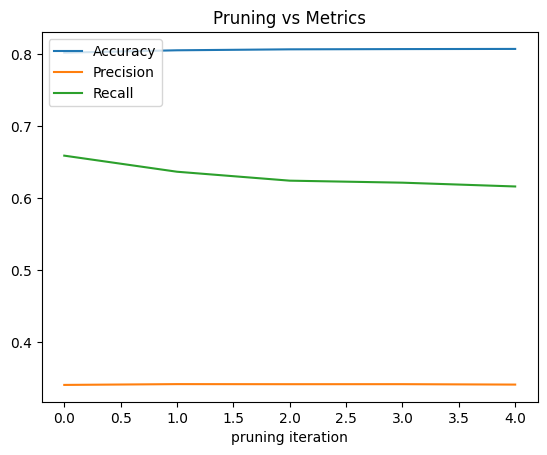

In [62]:
plotData(data, "Pruning vs Metrics", "pruning iteration")

In [81]:
print()
print("Collecting Data for different heights")
train_set, test_set = train_test_split(df, 0.8)
feature_set = set(FEATURE_TYPES.keys())
data_depth = []
for depth in range(1,20):
    print(f"Collecting Data for depth = {depth}")
    curTree =  DecisionTree(featureSet, LABEL, train_set[LABEL].unique(), "Root", depth)
    curTree.fitData(train_set)
    acc = GetAccuracy(curTree, test_set, False)
    pre = GetPrecision(curTree, test_set, False)
    rec = GetRecall(curTree, test_set, False)
    data.append([depth, acc, pre, rec])
    evaluateTree(curTree, test_set)
    data_depth.append((depth, acc, pre, rec))

    

    

Accuracy  = 0.8775866651478909 and Depth = 1
Precision = 0 and Depth = 1
Recall    = 0.0 and Depth = 1
The total number of nodes in the tree : 3
Accuracy  = 0.8775866651478909 and Depth = 2
Precision = 0 and Depth = 2
Recall    = 0.0 and Depth = 2
The total number of nodes in the tree : 7
Accuracy  = 0.712229942666211 and Depth = 3
Precision = 0.28357022164794754 and Depth = 3
Recall    = 0.8849255583126551 and Depth = 3
The total number of nodes in the tree : 11
Accuracy  = 0.761704066522383 and Depth = 4
Precision = 0.31029338637493786 and Depth = 4
Recall    = 0.7741935483870968 and Depth = 4
The total number of nodes in the tree : 20
Accuracy  = 0.761704066522383 and Depth = 5
Precision = 0.31029338637493786 and Depth = 5
Recall    = 0.7741935483870968 and Depth = 5
The total number of nodes in the tree : 32
Accuracy  = 0.7754869575122452 and Depth = 6
Precision = 0.31862943477674355 and Depth = 6
Recall    = 0.7326302729528535 and Depth = 6
The total number of nodes in the tree : 

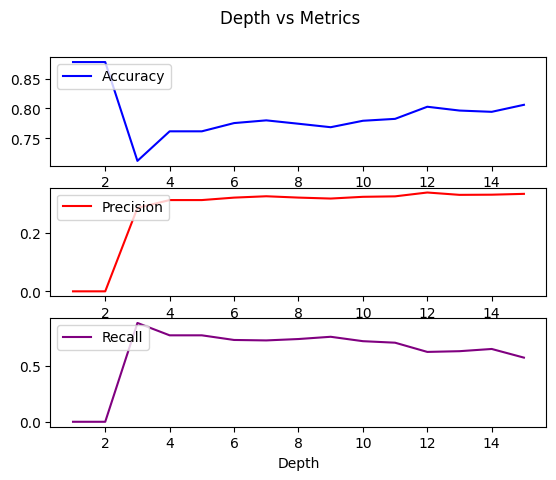

In [83]:
plotData(data_depth, "Depth vs Metrics", "Depth")

print("-------------------------Task-3-Completed-------------------------")
